# **Importing Necessary Library**

In [1]:
import re
import joblib
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skl2onnx import convert_sklearn
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from skl2onnx.common.data_types import StringTensorType
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# **Dataset Path**

In [2]:
df = pd.read_csv('D:\\Technohaven\\TF-IDF + Logistic Regression\\data\\Bangla-Text-Dataset.csv')

# **Dataset Information**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44001 entries, 0 to 44000
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               44001 non-null  object 
 1   Category              44001 non-null  object 
 2   Gender                44001 non-null  object 
 3   comment react number  43998 non-null  float64
 4   label                 44001 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


In [4]:
df.head()

,comment,Category,Gender,comment react number,label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully
4,পটকা মাছ,Politician,Male,0.0,troll


In [5]:
df.tail()

,comment,Category,Gender,comment react number,label
43996,"হিরো আলম,, এগিয়ে যাও",Social,Male,0.0,not bully
43997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,Social,Male,1.0,not bully
43998,হিরো ভাই তুমি এগিয়ে য়াও,Social,Male,0.0,not bully
43999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,Actor,Female,1.0,not bully
44000,হ্যালো তোমাদের সাথে কি আমাকে চ্যাট করবে,Social,Male,0.0,not bully


Taking only Comment and Label column, because other columns isn't necessary for Sentiment Analysis Classification

In [6]:
df = df[["comment", "label"]]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44001 entries, 0 to 44000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  44001 non-null  object
 1   label    44001 non-null  object
dtypes: object(2)
memory usage: 687.6+ KB


In [8]:
# Check the label distribution
print("-----Label distribution-----")
print(df['label'].value_counts())

-----Label distribution-----
label
not bully    15340
troll        10462
sexual        8928
religious     7577
threat        1694
Name: count, dtype: int64


# **Dataset Label Distribution Visualize**

C:\Users\SapphireFang\AppData\Local\Temp\ipykernel_36600\1740153592.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="Set1")


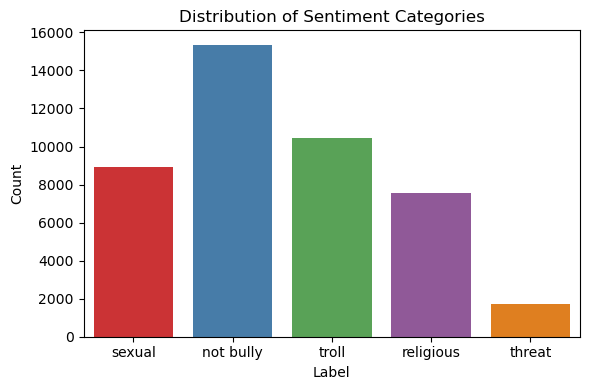

In [9]:
# Visualize the label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette="Set1")
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# **Data Preprocessing**

* Removed url's, emojis, punctuation and speacial characters, extra spaces
* Unicode normalization

In [10]:
# Data Preprocessing
def preprocess_bangla_text(text):
    """
    Preprocess Bangla text by removing special symbols, emojis, URLs, and extra spaces.
    Apply Unicode normalization.
    """
    if not isinstance(text, str):
        return ""
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove emojis (basic implementation)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation and special characters 
    text = re.sub(r'[^\w\s\u0980-\u09FF]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Apply Unicode normalization (NFC for composed characters)
    text = unicodedata.normalize('NFC', text)
    
    return text

In [11]:
# Apply preprocessing
df['processed_text'] = df['comment'].astype(str).apply(preprocess_bangla_text)

In [12]:
df

,comment,label,processed_text
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,sexual,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully,ঘরে বসে শুট করতে কেমন লেগেছে ক্যামেরাতে কে ছিলেন
2,"অরে বাবা, এই টা কোন পাগল????",not bully,অরে বাবা এই টা কোন পাগল
3,ক্যাপ্টেন অফ বাংলাদেশ,not bully,ক্যাপ্টেন অফ বাংলাদেশ
4,পটকা মাছ,troll,পটকা মাছ
...,...,...,...
43996,"হিরো আলম,, এগিয়ে যাও",not bully,হিরো আলম এগিয়ে যাও
43997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,not bully,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...
43998,হিরো ভাই তুমি এগিয়ে য়াও,not bully,হিরো ভাই তুমি এগিয়ে য়াও
43999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,not bully,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি


# Label Encoding

As we can see that the dataset have 5 labels, we performed multiclass classification

In [13]:
# Encode labels (multiclass)
label_map = {'not bully':0, 'religious':1, 'sexual':2, 'troll':3, 'threat':4}
df['encoded_label'] = df['label'].map(label_map)

In [14]:
df

,comment,label,processed_text,encoded_label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,sexual,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,2
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully,ঘরে বসে শুট করতে কেমন লেগেছে ক্যামেরাতে কে ছিলেন,0
2,"অরে বাবা, এই টা কোন পাগল????",not bully,অরে বাবা এই টা কোন পাগল,0
3,ক্যাপ্টেন অফ বাংলাদেশ,not bully,ক্যাপ্টেন অফ বাংলাদেশ,0
4,পটকা মাছ,troll,পটকা মাছ,3
...,...,...,...,...
43996,"হিরো আলম,, এগিয়ে যাও",not bully,হিরো আলম এগিয়ে যাও,0
43997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,not bully,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,0
43998,হিরো ভাই তুমি এগিয়ে য়াও,not bully,হিরো ভাই তুমি এগিয়ে য়াও,0
43999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,not bully,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,0


# Saving Preprocessed Dataset

In [15]:
df.to_csv('D:\\Technohaven\\TF-IDF + Logistic Regression\\data\\Bangla-Text-Dataset-Processed.csv', index=False)

# Train-Test Split (80-20 Ratio)

In [16]:
# Train-test split (80/20)
X = df['processed_text']
y = df['encoded_label']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['processed_text'], df['encoded_label'], test_size=0.2, random_state=42, stratify=y)

# **TF-IDF Vectorization**

In [17]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# **SMOTE Oversampling Technique**

In many real-world classification tasks, datasets suffer from class imbalance, where some classes have significantly more samples than others. This imbalance can bias the model toward the majority class, reducing performance on minority classes. 

To address this, we use SMOTE (Synthetic Minority Over-sampling Technique).

SMOTE generates synthetic samples for the minority classes by interpolating between existing minority samples in the feature space.

TF-IDF features are numeric and continuous, making them compatible with SMOTE. Applying SMOTE before training ensures that the classifier does not get biased toward overrepresented classes, leading to improved generalization and fairness across all classes.

# 🧠 How SMOTE Works
1. Identify Minority Class Samples:
    * SMOTE focuses only on the minority class (the class with fewer samples).

2. For Each Minority Sample:
    * Find its k nearest neighbors (typically k=5) among other minority class samples using a distance metric (e.g., Euclidean distance).

3. Generate Synthetic Samples:
    * Randomly select one or more neighbors.
    * For each neighbor, create a new synthetic sample using the following formula:

            synthetic_sample = original_sample + λ * (neighbor_sample - original_sample)

        where λ is a random number between 0 and 1.

4. Repeat Until Balanced:
    * Continue generating synthetic samples until the minority class has as many samples as the majority class.

In [18]:
# Handle imbalance with SMOTE on TF-IDF features
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_tfidf, y_train)
print("Resampled distribution:\n", pd.Series(y_res).value_counts())

c:\Users\SapphireFang\anaconda3\envs\Venom\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Resampled distribution:
 encoded_label
2    12272
3    12272
1    12272
0    12272
4    12272
Name: count, dtype: int64


In [19]:
X_res.shape , X_test_tfidf.shape

((61360, 100000), (8801, 100000))

# **Logistic Regression**

In [20]:
# Train LR
lr = LogisticRegression(max_iter=1000)
lr.fit(X_res, y_res)

LogisticRegression(max_iter=1000)

# **Classification Report**

In [21]:
# Predict and evaluate
y_pred_lr = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_lr, target_names=label_map.keys(), digits=5))

              precision    recall  f1-score   support

   not bully    0.72764   0.64179   0.68202      3068
   religious    0.47603   0.54389   0.50770      1515
      sexual    0.47652   0.42049   0.44676      1786
       troll    0.56782   0.46202   0.50948      2093
      threat    0.14562   0.46608   0.22191       339

    accuracy                        0.53051      8801
   macro avg    0.47873   0.50685   0.47358      8801
weighted avg    0.57294   0.53051   0.54552      8801



# **Confusion Matrix**

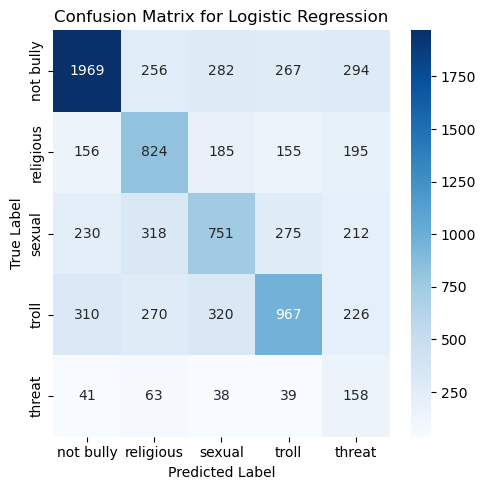

In [22]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.tight_layout()
plt.show()

# **Saving the Model**

In [23]:
# Save the Logistic Regression model
joblib.dump(lr, 'models/LogisticRegressionModel.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')

['models/tfidf_vectorizer.pkl']

# **Converting and Saving the Model into ONNX**

In [24]:
# --- ONNX Export ---

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('lr', lr)
])

initial_type = [('input', StringTensorType([None, 1]))]
onnx_model = convert_sklearn(pipeline, initial_types=initial_type)

with open("models/LogisticRegression_ONNX_Model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())